# Language Classification Simulation (English / Spanish / French)
This notebook trains a lightweight classifier on MFCC images stored in `MFCC_images/En`, `MFCC_images/Es`, `MFCC_images/Fr`. Run the cells in order; adjust paths if your data lives elsewhere.

- Purpose: quick baseline and model comparison on MFCC and spectrogram images.
- Datasets: folder-per-class with images inside.
- Output: accuracy per model and confusion matrices.


In [ ]:
# Installation note
# CUDA-enabled PyTorch install is handled below using %pip so it targets THIS kernel.
# Skip this cell. If you need to reinstall, use the CUDA install cell after diagnostics.
# (Left intentionally disabled to avoid conflicting installs)
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126


Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
# CUDA diagnostics and kernel path check
import sys, platform, torch
print(f"Python: {sys.version.split()[0]} on {platform.system()} {platform.release()}")
print(f"Interpreter: {sys.executable}")
print(f"PyTorch: {getattr(torch, '__version__', 'n/a')}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"torch.version.cuda: {torch.version.cuda}")
print(f"cuDNN available: {torch.backends.cudnn.is_available()}")
if torch.cuda.is_available():
    print(f"GPU count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        name = torch.cuda.get_device_name(i)
        print(f"  [{i}] {name} | CC {props.major}.{props.minor} | {(props.total_memory/1e9):.1f} GB")
else:
    print("CUDA is currently unavailable in this kernel.")


In [ ]:
# Install CUDA-enabled PyTorch into THIS kernel (restart required after install)
%pip uninstall -y torch torchvision torchaudio
# Use cu126 to best match your driver (CUDA 12.8)
%pip install --index-url https://download.pytorch.org/whl/cu126 torch torchvision torchaudio
print("Installed CUDA wheels. Please Restart Kernel, then re-run the diagnostics cell.")


In [ ]:
# Assert GPU availability before training (run after restarting and re-running diagnostics)
import torch
if not torch.cuda.is_available():
    raise RuntimeError(
        "CUDA is not available in this Jupyter kernel. "
        "Run the CUDA install cell with %pip, restart the kernel, "
        "then re-run the diagnostics cell."
    )
print("CUDA available. Proceeding with GPU training.")


In [12]:
# Environment setup and reproducibility
import os
import random
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

# Reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# Prefer CUDA when available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = device.type == "cuda"
if device.type == "cuda":
    pin_memory = True
    non_blocking = True
    try:
        torch.backends.cudnn.benchmark = True
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass
    print(f"Using device: {device} (GPU count: {torch.cuda.device_count()})")
    try:
        print(f"Current GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    except Exception:
        pass
    print(f"torch.version.cuda: {torch.version.cuda}")
else:
    pin_memory = False
    non_blocking = False
    print(f"Using device: {device} | CUDA available: {torch.cuda.is_available()} | torch.version.cuda: {torch.version.cuda}")

Using device: cpu | CUDA available: False | torch.version.cuda: None


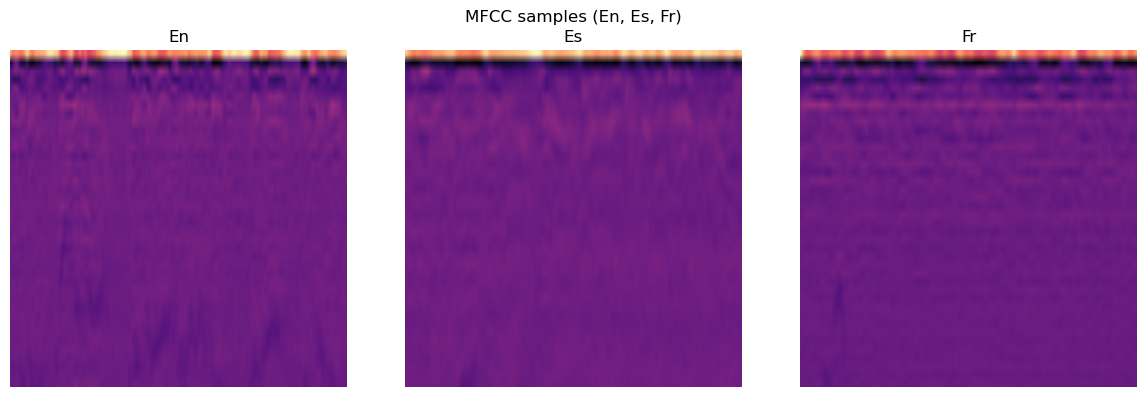

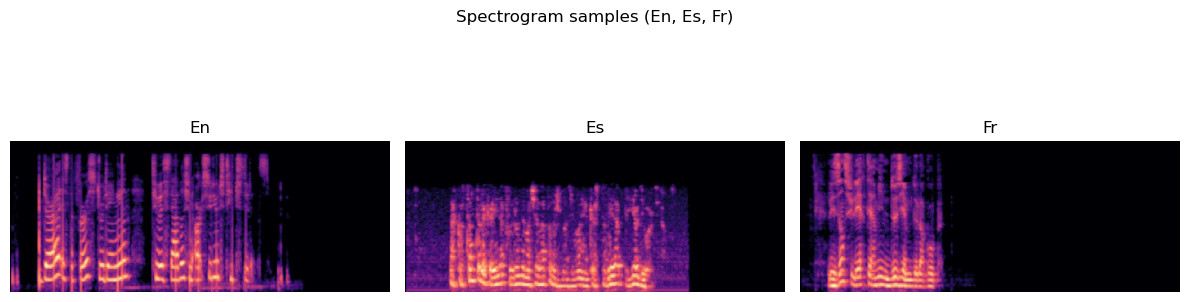

In [ ]:
# Quick visual sanity check: show MFCC and spectrogram examples
# - Loads one image per language for MFCC and Spectrogram
# - Helps verify paths and class folder names (En/Es/Fr)
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

mfcc_samples = [
    Path("MFCC_images/En/common_voice_en_40205636_mfcc.png"),
    Path("MFCC_images/Es/common_voice_es_40198330_mfcc.png"),
    Path("MFCC_images/Fr/common_voice_fr_40211225_mfcc.png"),
]

spectro_samples = [
    Path("spectrogram_images/En/common_voice_en_40323223.jpg"),
    Path("spectrogram_images/Es/common_voice_es_40198121.jpg"),
    Path("spectrogram_images/Fr/common_voice_fr_40211219.jpg"),
]

def show_images(paths, title):
    cols = len(paths)
    plt.figure(figsize=(4 * cols, 4))
    for i, p in enumerate(paths, 1):
        img = Image.open(p).convert("RGB")
        ax = plt.subplot(1, cols, i)
        ax.imshow(img)
        ax.set_title(p.parent.name)
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images(mfcc_samples, "MFCC samples (En, Es, Fr)")
show_images(spectro_samples, "Spectrogram samples (En, Es, Fr)")

In [ ]:
# Dataset builders for MFCC and Spectrogram (using torchvision ImageFolder)
from pathlib import Path
from torch.utils.data import DataLoader, random_split
import torch
from torchvision import transforms, datasets

IMG_SIZE = 128
BATCH_SIZE = 16
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

basic_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

def build_loaders(root_dir: str):
    ds = datasets.ImageFolder(root=root_dir, transform=basic_transform)
    full_len = len(ds)
    val_len = int(full_len * VAL_SPLIT)
    test_len = int(full_len * TEST_SPLIT)
    train_len = full_len - val_len - test_len
    train_ds, val_ds, test_ds = random_split(ds, [train_len, val_len, test_len])
    # Use pin_memory when running on CUDA for faster host->device copies
    pm = globals().get('pin_memory', False)
    return {
        "train": DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=pm),
        "val": DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pm),
        "test": DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pm),
        "classes": ds.classes,
    }

mfcc_root = str(Path("MFCC_images"))
spectro_root = str(Path("spectrogram_images"))

mfcc_data = build_loaders(mfcc_root)
spectro_data = build_loaders(spectro_root)

print("MFCC classes:", mfcc_data["classes"])
print("Spectrogram classes:", spectro_data["classes"])

MFCC classes: ['En', 'Es', 'Fr']
Spectrogram classes: ['En', 'Es', 'Fr']


In [3]:
def make_resnet18(num_classes=3):

    from torchvision import models
    m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

In [4]:
# Model builders: SmallCNN, VGG16, AlexNet, ResNet18, CNNLSTM
# - Includes lightweight `SmallCNN` that works without torchvision
# - CNNLSTM slices the image along height to simulate time steps
import math
from torch import nn

class SmallCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE//8) * (IMG_SIZE//8), 256), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
)
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

def make_vgg16(num_classes=3):
    from torchvision import models
    m = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, num_classes)
    return m

def make_alexnet(num_classes=3):
    from torchvision import models
    m = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
    m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, num_classes)
    return m

def make_resnet18(num_classes=3):
    from torchvision import models
    m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

class CNNLSTM(nn.Module):
    def __init__(self, num_classes=3, slices=8):
        super().__init__()
        self.slices = slices
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
)
        self.cnn_out = 64 * (IMG_SIZE//4) * (IMG_SIZE//(4*self.slices))
        self.proj = nn.Linear(self.cnn_out, 256)
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
        self.head = nn.Linear(128, num_classes)
    def forward(self, x):
        B, C, H, W = x.shape
        slice_h = H // self.slices
        seq_feats = []
        for i in range(self.slices):
            band = x[:, :, i*slice_h:(i+1)*slice_h, :]
            f = self.cnn(band)
            f = f.reshape(B, -1)
            f = self.proj(f)
            seq_feats.append(f)
        seq = torch.stack(seq_feats, dim=1)
        out, _ = self.lstm(seq)
        last = out[:, -1, :]
        return self.head(last)

In [ ]:
# Training and evaluation utilities

import time
import numpy as np
from typing import Dict, List, Tuple
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch import nn
import torch.nn.functional as F

# Ensure loaders exist
from pathlib import Path
IMG_SIZE = globals().get('IMG_SIZE', 128)
BATCH_SIZE = globals().get('BATCH_SIZE', 16)
VAL_SPLIT = globals().get('VAL_SPLIT', 0.15)
TEST_SPLIT = globals().get('TEST_SPLIT', 0.15)
from torchvision import transforms, datasets
basic_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

def build_loaders(root_dir: str):
    ds = datasets.ImageFolder(root=root_dir, transform=basic_transform)
    full_len = len(ds)
    val_len = int(full_len * VAL_SPLIT)
    test_len = int(full_len * TEST_SPLIT)
    train_len = full_len - val_len - test_len
    from torch.utils.data import random_split
    train_ds, val_ds, test_ds = random_split(ds, [train_len, val_len, test_len])
    pm = globals().get('pin_memory', False)
    return {
        "train": DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=pm),
        "val": DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pm),
        "test": DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=pm),
        "classes": ds.classes,
    }

mfcc_root = str(Path("MFCC_images"))
spectro_root = str(Path("spectrogram_images"))
mfcc_data = build_loaders(mfcc_root)
spectro_data = build_loaders(spectro_root)

from torch.cuda.amp import autocast, GradScaler

def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None, use_amp=False):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    nb = globals().get('non_blocking', False)
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=nb)
        yb = torch.as_tensor(yb, device=device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=use_amp):
            logits = model(xb)
            loss = criterion(logits, yb)
        if scaler is not None and use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total_loss += float(loss) * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += int((preds == yb).sum())
        total += xb.size(0)
    return total_loss / max(total, 1), correct / max(total, 1)

def evaluate(model, loader, criterion, device, use_amp=False):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_targets = [], []
    nb = globals().get('non_blocking', False)
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=nb)
            yb = torch.as_tensor(yb, device=device)
            with autocast(enabled=use_amp):
                logits = model(xb)
                loss = criterion(logits, yb)
            total_loss += float(loss) * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += int((preds == yb).sum())
            total += xb.size(0)
            all_preds.append(preds.detach().cpu().numpy())
            all_targets.append(yb.detach().cpu().numpy())
    avg_loss = total_loss / max(total, 1)
    acc = correct / max(total, 1)
    y_pred = np.concatenate(all_preds) if all_preds else np.array([])
    y_true = np.concatenate(all_targets) if all_targets else np.array([])
    return avg_loss, acc, y_true, y_pred

def run_training(model_builder, data: Dict[str, DataLoader], name: str, epochs=6, lr=1e-3, patience=3):
    dev = globals().get('device', torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    model = model_builder().to(dev)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    use_amp_local = dev.type == 'cuda'
    scaler = GradScaler(enabled=use_amp_local)
    if dev.type == 'cuda':
        torch.backends.cudnn.benchmark = True
    best_val_loss = float('inf')
    best_state = None
    wait = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, data["train"], criterion, optimizer, dev, scaler=scaler, use_amp=use_amp_local)
        val_loss, val_acc, _, _ = evaluate(model, data["val"], criterion, dev, use_amp=use_amp_local)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"[{name}] Epoch {ep:02d} | train_loss={tr_loss:.4f} acc={tr_acc:.3f} | val_loss={val_loss:.4f} acc={val_acc:.3f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"[{name}] Early stopping at epoch {ep}")
                break
    if best_state is not None:
        model.load_state_dict(best_state)
        model.to(dev)
    test_loss, test_acc, y_true, y_pred = evaluate(model, data["test"], criterion, dev, use_amp=use_amp_local)
    print(f"[{name}] Test loss={test_loss:.4f} acc={test_acc:.3f}")
    return model, history, (test_loss, test_acc, y_true, y_pred)

## Model comparison overview
# - Builds a list of models to train (torchvision required for some)
# - Trains each on MFCC data by default (switch to spectrograms if desired)
# - Prints confusion matrix and classification report per model, then summary

models_to_run = []
models_to_run.append(("SmallCNN", lambda: SmallCNN(num_classes=3)))
models_to_run.append(("CNNLSTM", lambda: CNNLSTM(num_classes=3, slices=8)))
models_to_run.extend([
    ("ResNet18", lambda: make_resnet18(num_classes=3)),
    ("AlexNet", lambda: make_alexnet(num_classes=3)),
    ("VGG16", lambda: make_vgg16(num_classes=3)),
])

results = []
best_overall_acc = -1.0
best_model = None
best_y_true = None
best_y_pred = None
data = mfcc_data  # change to spectro_data to compare on spectrograms
classes = data["classes"]
for name, builder in models_to_run:
    print(f"\n=== Training {name} on MFCC images ===")
    model, history, (tl, ta, y_true, y_pred) = run_training(builder, data, name=name, epochs=6, lr=1e-3, patience=3)
    results.append({"name": name, "test_loss": tl, "test_acc": ta})
    if ta > best_overall_acc and y_true.size and y_pred.size:
        best_overall_acc = ta
        best_model = model
        best_y_true = y_true
        best_y_pred = y_pred
    if y_true.size and y_pred.size:
        cm = confusion_matrix(y_true, y_pred)
        print(f"Confusion Matrix ({name}):\n{cm}")
        report = classification_report(y_true, y_pred, target_names=classes)
        print(report)

print("\nSummary:")
for r in sorted(results, key=lambda x: x["test_acc"], reverse=True):
    print(f"{r['name']}: acc={r['test_acc']:.3f} loss={r['test_loss']:.4f}")
if best_model is not None:
    print(f"Best cached model: acc={best_overall_acc:.3f}")
else:
    print("Best cached model unavailable (no predictions cached).")


=== Training SmallCNN on MFCC images ===


C:\Users\Lukita\AppData\Local\Temp\ipykernel_7568\535836475.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(device), torch.tensor(yb).to(device)
C:\Users\Lukita\AppData\Local\Temp\ipykernel_7568\535836475.py:55: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  total_loss += float(loss) * xb.size(0)
C:\Users\Lukita\AppData\Local\Temp\ipykernel_7568\535836475.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(device), torch.ten

[SmallCNN] Epoch 01 | train_loss=0.8766 acc=0.578 | val_loss=0.7140 acc=0.681
[SmallCNN] Epoch 02 | train_loss=0.7153 acc=0.672 | val_loss=0.6467 acc=0.717
[SmallCNN] Epoch 03 | train_loss=0.6415 acc=0.721 | val_loss=0.6041 acc=0.731
[SmallCNN] Epoch 04 | train_loss=0.5746 acc=0.753 | val_loss=0.5638 acc=0.762
[SmallCNN] Epoch 05 | train_loss=0.5151 acc=0.784 | val_loss=0.5308 acc=0.782
[SmallCNN] Epoch 06 | train_loss=0.4504 acc=0.818 | val_loss=0.5314 acc=0.785
[SmallCNN] Test loss=0.5406 acc=0.770
Confusion Matrix (SmallCNN):
[[733 113  88]
 [144 893  45]
 [112  70 293]]
              precision    recall  f1-score   support

          En       0.74      0.78      0.76       934
          Es       0.83      0.83      0.83      1082
          Fr       0.69      0.62      0.65       475

    accuracy                           0.77      2491
   macro avg       0.75      0.74      0.75      2491
weighted avg       0.77      0.77      0.77      2491


=== Training CNNLSTM on MFCC images =

C:\Users\Lukita\AppData\Local\Temp\ipykernel_7568\535836475.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(device), torch.tensor(yb).to(device)
C:\Users\Lukita\AppData\Local\Temp\ipykernel_7568\535836475.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(device), torch.tensor(yb).to(device)


[CNNLSTM] Epoch 01 | train_loss=0.9663 acc=0.530 | val_loss=0.8518 acc=0.616
[CNNLSTM] Epoch 02 | train_loss=0.8425 acc=0.615 | val_loss=0.8921 acc=0.589
[CNNLSTM] Epoch 03 | train_loss=0.7503 acc=0.665 | val_loss=0.7160 acc=0.686
[CNNLSTM] Epoch 04 | train_loss=0.6960 acc=0.695 | val_loss=0.7112 acc=0.695
[CNNLSTM] Epoch 05 | train_loss=0.6474 acc=0.724 | val_loss=0.6581 acc=0.715
[CNNLSTM] Epoch 06 | train_loss=0.6012 acc=0.741 | val_loss=0.6494 acc=0.728
[CNNLSTM] Test loss=0.6792 acc=0.722
Confusion Matrix (CNNLSTM):
[[660 194  80]
 [120 923  39]
 [110 150 215]]
              precision    recall  f1-score   support

          En       0.74      0.71      0.72       934
          Es       0.73      0.85      0.79      1082
          Fr       0.64      0.45      0.53       475

    accuracy                           0.72      2491
   macro avg       0.70      0.67      0.68      2491
weighted avg       0.72      0.72      0.71      2491


=== Training ResNet18 on MFCC images ===
Down

100%|██████████| 44.7M/44.7M [00:04<00:00, 10.0MB/s]
C:\Users\Lukita\AppData\Local\Temp\ipykernel_7568\535836475.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(device), torch.tensor(yb).to(device)
C:\Users\Lukita\AppData\Local\Temp\ipykernel_7568\535836475.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(device), torch.tensor(yb).to(device)


[ResNet18] Epoch 01 | train_loss=0.7267 acc=0.690 | val_loss=0.9087 acc=0.684
[ResNet18] Epoch 02 | train_loss=0.5018 acc=0.800 | val_loss=0.4878 acc=0.800
[ResNet18] Epoch 03 | train_loss=0.3878 acc=0.849 | val_loss=0.4409 acc=0.817
[ResNet18] Epoch 04 | train_loss=0.3093 acc=0.881 | val_loss=0.3946 acc=0.847
[ResNet18] Epoch 05 | train_loss=0.2388 acc=0.913 | val_loss=0.3672 acc=0.859
[ResNet18] Epoch 06 | train_loss=0.1951 acc=0.929 | val_loss=0.3455 acc=0.874
[ResNet18] Test loss=0.4373 acc=0.842
Confusion Matrix (ResNet18):
[[773 115  46]
 [ 75 983  24]
 [ 54  80 341]]
              precision    recall  f1-score   support

          En       0.86      0.83      0.84       934
          Es       0.83      0.91      0.87      1082
          Fr       0.83      0.72      0.77       475

    accuracy                           0.84      2491
   macro avg       0.84      0.82      0.83      2491
weighted avg       0.84      0.84      0.84      2491


=== Training AlexNet on MFCC images =

C:\Users\Lukita\AppData\Local\Temp\ipykernel_7568\535836475.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(device), torch.tensor(yb).to(device)
C:\Users\Lukita\AppData\Local\Temp\ipykernel_7568\535836475.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(device), torch.tensor(yb).to(device)


[AlexNet] Epoch 01 | train_loss=1.0745 acc=0.425 | val_loss=1.0541 acc=0.444
[AlexNet] Epoch 02 | train_loss=1.0618 acc=0.425 | val_loss=1.0538 acc=0.444
[AlexNet] Epoch 03 | train_loss=1.0606 acc=0.431 | val_loss=1.0536 acc=0.444
[AlexNet] Epoch 04 | train_loss=1.0606 acc=0.430 | val_loss=1.0544 acc=0.444
[AlexNet] Epoch 05 | train_loss=1.0598 acc=0.429 | val_loss=1.0532 acc=0.444
[AlexNet] Epoch 06 | train_loss=1.0596 acc=0.432 | val_loss=1.0558 acc=0.444
[AlexNet] Test loss=1.0465 acc=0.434
Confusion Matrix (AlexNet):
[[   0  934    0]
 [   0 1082    0]
 [   0  475    0]]
              precision    recall  f1-score   support

          En       0.00      0.00      0.00       934
          Es       0.43      1.00      0.61      1082
          Fr       0.00      0.00      0.00       475

    accuracy                           0.43      2491
   macro avg       0.14      0.33      0.20      2491
weighted avg       0.19      0.43      0.26      2491


=== Training VGG16 on MFCC images ==

c:\Users\Lukita\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lukita\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lukita\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lukita\AppData\Local\Temp\ip

[VGG16] Epoch 01 | train_loss=1.0906 acc=0.414 | val_loss=1.0622 acc=0.444


KeyboardInterrupt: 

In [ ]:
# Visualization: plot model evaluation summary

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Expect `results`, `classes`, and cached predictions from previous cell
assert isinstance(results, list) and len(results) > 0, "No results found. Please run the training/comparison cell first."

names = [r['name'] for r in results]
accs = [r['test_acc'] for r in results]
losses = [r['test_loss'] for r in results]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
bars = plt.bar(names, accs, color='tab:blue')
plt.title('Test Accuracy by Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right')
for b, a in zip(bars, accs):
    plt.text(b.get_x() + b.get_width()/2, a + 0.01, f"{a:.2f}", ha='center', va='bottom', fontsize=9)

plt.subplot(1,2,2)
bars2 = plt.bar(names, losses, color='tab:orange')
plt.title('Test Loss by Model')
plt.ylabel('Loss')
plt.xticks(rotation=30, ha='right')
for b, l in zip(bars2, losses):
    plt.text(b.get_x() + b.get_width()/2, l + 0.01, f"{l:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Optional: confusion matrix of the best model if stored
best_idx = int(np.argmax(accs))
best_name = names[best_idx]
print(f"Best model: {best_name}")

# Initialize prediction arrays from globals; plot only when available
best_y_true = globals().get('best_y_true', None)
best_y_pred = globals().get('best_y_pred', None)

if best_y_true is not None and best_y_pred is not None:
    cm = confusion_matrix(best_y_true, best_y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix ({best_name})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
else:
    print("Confusion matrix skipped: best_y_true/best_y_pred not available. Run the training cell to cache predictions.")

RuntimeError: No results found. Please run the training/comparison cell first.